In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cpu


In [2]:
# Görseller için dönüşümler
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Dataset yolları
data_dir = "data"

train_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

print("Toplam örnek sayısı:", len(train_dataset))
print("Sınıflar:", train_dataset.classes)



Toplam örnek sayısı: 80
Sınıflar: ['negative', 'positive']


In [3]:
from torch.utils.data import random_split

# %75 train, %25 test
train_size = int(0.75 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_ds, test_ds = random_split(
    train_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False)

print("Train örnek:", len(train_ds))
print("Test örnek:", len(test_ds))



Train örnek: 60
Test örnek: 20


In [4]:
# Daha hızlı olsun diye resnet18 kullanıyoruz (CPU'da mantıklı)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Feature extractor'ı dondur
for param in model.parameters():
    param.requires_grad = False

# Son katmanı 2 sınıf için değiştir
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("Model hazır:", type(model).__name__)


Model hazır: ResNet


In [5]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

epochs = 3
for epoch in range(epochs):
    loss, train_acc = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} | loss={loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")


Epoch 1/3 | loss=0.8758 | train_acc=0.467 | test_acc=0.500
Epoch 2/3 | loss=0.7017 | train_acc=0.600 | test_acc=0.500
Epoch 3/3 | loss=0.7394 | train_acc=0.517 | test_acc=0.500


In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

y_true = []
y_pred = []
y_score = []  # positive class olasılığı

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)                 # (batch, 2)
        probs = torch.softmax(outputs, dim=1)   # olasılıklar

        preds = probs.argmax(dim=1).cpu().numpy()
        pos_scores = probs[:, 1].cpu().numpy()  # class=1 (positive) skoru

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_score.extend(pos_scores)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

print("Test örnek:", len(y_true))


Test örnek: 20


In [7]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
 [[5 4]
 [6 5]]

Classification Report:
               precision    recall  f1-score   support

           0      0.455     0.556     0.500         9
           1      0.556     0.455     0.500        11

    accuracy                          0.500        20
   macro avg      0.505     0.505     0.500        20
weighted avg      0.510     0.500     0.500        20



ROC-AUC: 0.5050505050505051


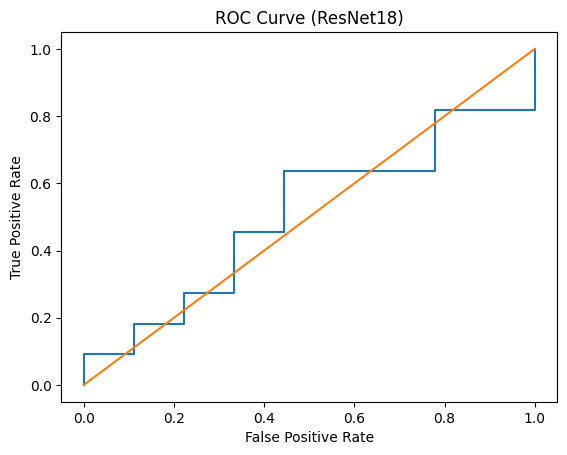

In [8]:
auc = roc_auc_score(y_true, y_score)
fpr, tpr, _ = roc_curve(y_true, y_score)

print("ROC-AUC:", auc)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet18)")
plt.show()


Test örnek sayısı: 20
Confusion Matrix:
 [[5 4]
 [6 5]]

Classification Report:

              precision    recall  f1-score   support

    negative       0.45      0.56      0.50         9
    positive       0.56      0.45      0.50        11

    accuracy                           0.50        20
   macro avg       0.51      0.51      0.50        20
weighted avg       0.51      0.50      0.50        20

ROC-AUC: 0.5050505050505051


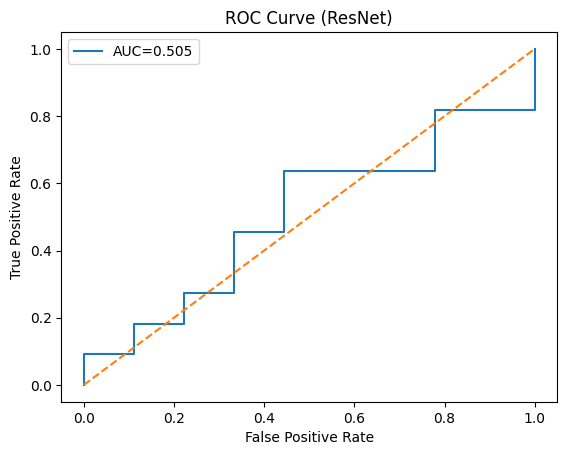

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_true = []
y_pred = []
y_score = []  # positive class olasılığı

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)                 # (batch, 2)
        probs = torch.softmax(outputs, dim=1)   # olasılıklar

        preds = probs.argmax(dim=1).cpu().numpy()
        pos_scores = probs[:, 1].cpu().numpy()  # class=1 (positive)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_score.extend(pos_scores)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

print("Test örnek sayısı:", len(y_true))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

auc = roc_auc_score(y_true, y_score)
fpr, tpr, _ = roc_curve(y_true, y_score)

print("ROC-AUC:", auc)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet)")
plt.legend()
plt.show()
